In [1]:
import numpy as np
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt


Reference: Modelling the polymerisation of methyl
methacrylate (MMA) in a partially stirred reactor.

Jethro Akroyd, Markus Kraft1, Elmar St¨ockelmann2
ISSN 1473 – 4273

In [2]:
#special functions
def Arrhenius_joules( A, Ea, T):
    """
    calculates a rate constant from the Arrhenius equation
    inputs are the pre-exponential factor, the energy of activation 
    and the temperature in Centigrade
    returns the rate constant but units are user controlled
    default R in Joules
    """
    R= 8.3144 # j/K/mol
    TK = T +273.15
    return A*np.exp(-Ea/(R*TK))

def Arrhenius_cal( A, Ea, T):
    """
    calculates a rate constant from the Arrhenius equation
    inputs are the pre-exponential factor, the energy of activation 
    and the temperature in Centigrade
    returns the rate constant but units are user controlled
    default R in calories, NOT kilocalories
    """
    R = 1.9872 #cal/(K mol)
    TK = T +273.15
    return A*np.exp(-Ea/(R*TK))


In [3]:
format_and_print = lambda nums: print(' '.join([f'{num:.3e}' for num in nums])) #[1=>many items are printed]

In [4]:
#Initialize each element of the species to be integrated
I0 = 0.01548 #from paper
M0 = 4.32    #from pper
lam0= 2e-9
lam1= 2e-9
lam2= 2e-9
mu0=  2e-9 
mu1=  2e-9
mu2 = 2e-9
#parameter set to be sent to integrator
y0 = [I0, M0, lam0, lam1, lam2, mu0, mu1, mu2,]
#format_and_print (y0)

In [5]:
# Define kinetic parameters from paper
f = 0.3
kd = 1.5e-5
kp =7.594e+2 # Propagation rate constant (m^3/kmol/sec)  Kraft Thesis
ki = kp # Initiation rate constant (m^3/kmol/sec)
ktc = 24.15e+6 #termination by combination (m^3/kmol/sec)
ktd = 10.35e+6 # Termination by disproportionation (m^3/kmol/sec)
ktrm = 1.78e-2 # Transfer to monomer (m^3/kmol/sec)
kt = ktc + ktd
values = [f, kd, kp, ki, ktc, ktd, ktrm, kt]
format_and_print (values)

3.000e-01 1.500e-05 7.594e+02 7.594e+02 2.415e+07 1.035e+07 1.780e-02 3.450e+07


In [6]:
def poly_kraft(t,y):
#Kraft Thesis
    I , M, lam0,lam1,lam2,mu0,mu1,mu2 = y
    if(M<0):
        M=0
    if(I<0):
        I=0
    if(mu0 < 0):
        mu0 = 0
    if(mu1 < 0):
        mu1 = 0
    if(mu2 < 0):
        mu2 = 0
    if(mu0 == 1.e-20):
        lambda0 = 1.e-20
    
    dIdt = -kd*I
    dMdt = -mu0*M*(kp+ktrm) - 2.*f*kd*I
    #dead moments
    dlam0dt = 2*f*kd*I + mu0 *ktrm*M - .5*mu0*mu0*ktc
    dlam1dt = 2*f*kd*I + mu0 *(kp+ktrm)*M
    dlam2dt = 2*f*kd*I + mu0 *(kp+ktrm)*M + 2*mu1*kp*M +mu1*mu1*ktc
    #live moments
    dmu0dt =  2*f*kd*I - mu0 * mu0*(ktc+ktd)
    dmu1dt =  2*f*kd*I - (mu1-mu0)*ktrm*M - mu1 * mu0 *(ktc+ktd) + mu0*kp*M
    dmu2dt =  2*f*kd*I - (mu2-mu0)*ktrm*M - mu2 * mu0 *(ktc+ktd) + (2 * mu1 + mu0)*kp*M
    #return 8 values indexed 0-0
    return [dIdt, dMdt, dlam0dt, dlam1dt, dlam2dt, dmu0dt, dmu1dt, dmu2dt ]

In [7]:
# Solve ODE system using numerical integration
t0 = 0 # [min] Initial time
tf = 50000 # [min] Final time from paper
abserr = 1.e-8 
relerr = 1.e-8
t_pts = np.linspace(t0, tf, 1000)  # 1000 points between t=t0 and t=tf. OPTIONAL
# this configuration is usually good
#sol =  solve_ivp(poly_kraft, (t0, tf), y0 ,rtol=relerr, atol=abserr, method='BDF', dense_output=True ) 
#my preferred starting configuration
sol =  solve_ivp(poly_kraft, (t0, tf), y0, t_eval=t_pts,rtol=relerr, atol=abserr, method='BDF', dense_output=True )  

In [8]:
#uncomment the next line to get additional, but not too helpful, indo
#sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.005e+01 ...  4.995e+04  5.000e+04]
        y: [[ 1.548e-02  1.547e-02 ...  7.318e-03  7.312e-03]
            [ 4.320e+00  4.310e+00 ...  5.766e-01  5.756e-01]
            ...
            [ 2.000e-09  9.172e-05 ...  1.265e-05  1.263e-05]
            [ 2.000e-09  2.648e-01 ...  7.312e-03  7.290e-03]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000026EFFD1C910>
 t_events: None
 y_events: None
     nfev: 525
     njev: 3
      nlu: 47

In [9]:
print (sol.y.shape)
#will be an array of: (# of returned values, t_pts)


(8, 1000)


In [10]:
#print out values for comparison if needed
print(f'Initial value of Initiator: {I0:.3e} final value of initiator: {sol.y[0][-1]: .3e}'  )
print(f'Initial value of Monomer:   {M0:.3e}   final value of Monomer: {sol.y[1][-1]: .3e}'  )
print(f'Final value of Conversion:  {1-(sol.y[1][-1])/M0:.3e}' )


Initial value of Initiator: 1.548e-02 final value of initiator:  7.312e-03
Initial value of Monomer:   4.320e+00   final value of Monomer:  5.756e-01
Final value of Conversion:  8.668e-01


In [11]:
#key for ploting desired values
#dIdt, dMdt, dlam0dt, dlam1dt, dlam2dt, dmu0dt, dmu1dt, dmu2dt 
#  0     1       2      3        4        5       6      7
def Plot_Components(ode_result):
    global PD
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0,0].plot(sol.t, sol.y[1,:], '-r', label ='Monomer') 
    axs[0,0].set_xlabel('Time')
    axs[0,0].grid()
    axs[0,0].set_title('Monomer')
    axs[0,0].legend(loc='best')
    plt.grid()
    #
    axs[0,1].plot(sol.t, sol.y[0,:], '-b',label ='Initiator') 
    axs[0,1].set_xlabel('Time')
    axs[0,1].grid()
    axs[0,1].set_title('Initiator')
    axs[0,1].legend(loc='best')
   # plt.legend()
    plt.grid()
    #
    conversion =1 - (sol.y[1,:]/M0 )
    axs[1,0].plot(sol.t, conversion,'-y', label ='Conversion') 
    axs[1,0].set_xlabel('Time')
    axs[1,0].grid()
    axs[1,0].set_title('Conversion')
    axs[1,0].legend(loc='best')
    plt.grid()
    # [dIdt, dMdt, dlam0dt, dlam1dt, dlam2dt, dmu0dt, dmu1dt, dmu2dt ]
    # the equations below match the document
    num  =   (sol.y[3,1:] - sol.y[6,1:])
    denom =  (sol.y[2,1:] - sol.y[5,1:]) 
    num2  =  (sol.y[4,1:] - sol.y[7,1:]) 
    denom2 = (sol.y[3,1:] - sol.y[6,1:]) 
    PD = (num2/denom2) / (num/denom)
    axs[1,1].plot(sol.t[1:],  PD,  '-g',label='Polydispersity ')
    axs[1,1].set_xlabel('Time')
    axs[1,1].grid()
    axs[1,1].set_title('Polydispersity')
    axs[1,1].legend(loc='best')
    plt.grid()
    for ax in axs.flat:
        ax.set(xlabel='Time', ylabel='Concentration or Fraction')
    print(f'final value of Polydispersity: {PD[-1]: .3e}' )
    return


final value of Polydispersity:  2.105e+00


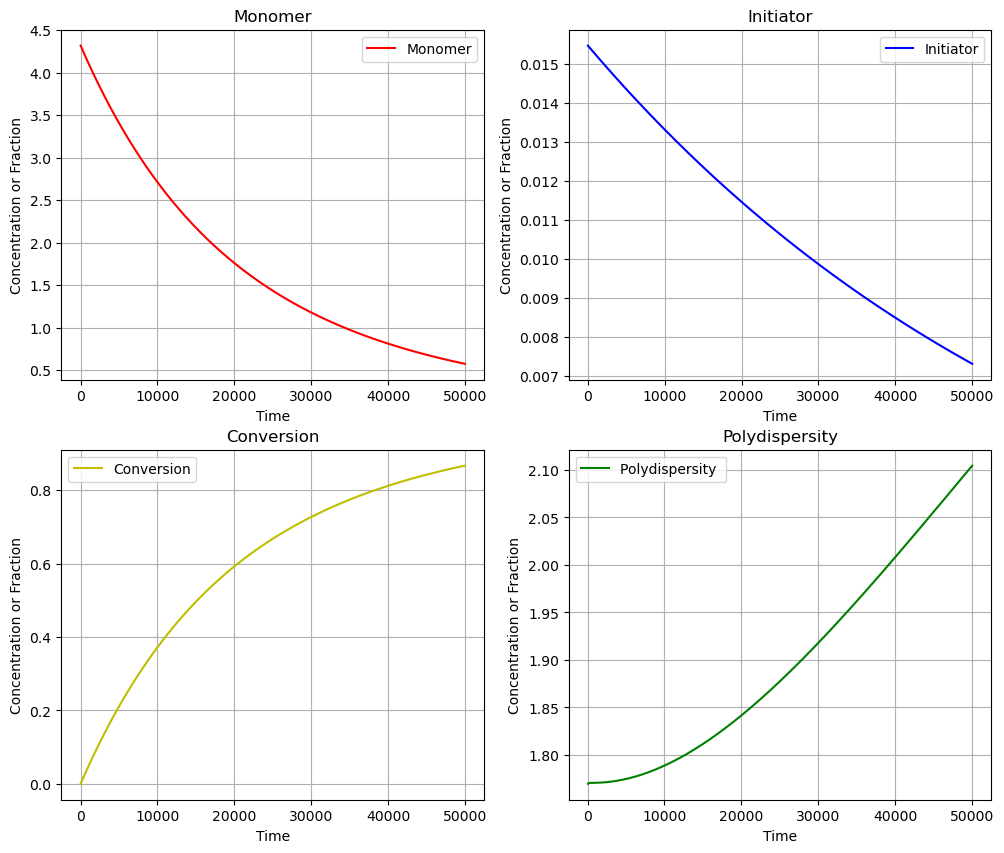

In [12]:
Plot_Components(sol)

Final Mn =  2407.601102877213
Final Mn =  1144.0021078183274
Final PD =  2.105e+00


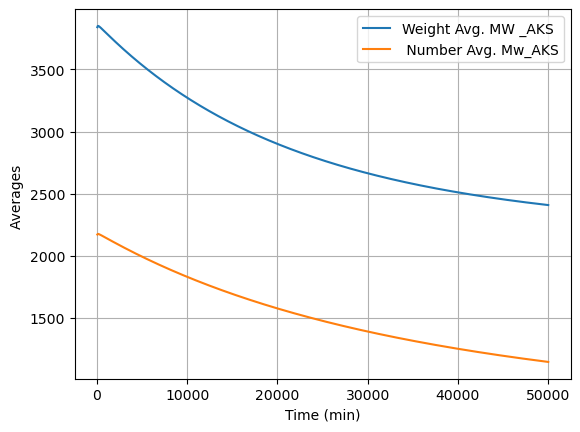

In [13]:
#key for ploting desired values
#dIdt, dMdt, dlam0dt, dlam1dt, dlam2dt, dmu0dt, dmu1dt, dmu2dt 
#  0     1       2      3        4        5       6      7

# the equations below match the document
#Weight Average
num2  =  (sol.y[4,1:] - sol.y[7,1:]) 
denom2 = (sol.y[3,1:] - sol.y[6,1:]) 
plt.plot(sol.t[1:], num2/denom2,  label='Weight Avg. MW _AKS')
print('Final Mn = ', num2[-1]/denom2[-1])
#Number Average
num  =   (sol.y[3,1:] - sol.y[6,1:])
denom =  (sol.y[2,1:] - sol.y[5,1:]) 
print('Final Mn = ', num[-1]/denom[-1])
plt.plot(sol.t[1:], num/denom,  label=' Number Avg. Mw_AKS')

print(f'Final PD = {PD[-1]: .3e}' )

plt.xlabel('Time (min)')
plt.ylabel('Averages ')
plt.legend() 
plt.grid()
plt.show()